In [1]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from results_functions import calculate_spikes_predicted, plot_confusion_matrix, draw_predictions

In [ ]:
#Cargar los distintos datos

# Spikes
vix_data = pd.read_excel("output/vix_model_data.xlsx")
vix_data['Year'] = vix_data["Trade Date"].dt.year
spikes = vix_data[vix_data["Spike"] == "Yes"]
spikes = spikes[["Trade Date", "VIX", "Year"]]
spikes.set_index('Trade Date', inplace=True)
# Cargar los datos
model_data = pd.read_excel("output/model_data_spike_5d.xlsx")
model_data['Year'] = model_data["Trade Date"].dt.year
model_data.set_index('Trade Date', inplace=True)

# Datos de 2024 y 2025
data_last_2y = model_data[(model_data.Year == 2025) | (model_data.Year == 2024)]

# Datos de 2025
data_last_y =  model_data[(model_data.Year == 2025)]

# Datos para entrenar al modelo, hasta 2023
model_data = model_data[~((model_data.Year == 2025) | (model_data.Year == 2024))]

# Eliminar columnas innecesarias
if "Futures Curve Skew" in model_data.columns:
    model_data = model_data.drop(columns=["Futures Curve Skew"])
    data_last_2y = data_last_2y.drop(columns=["Futures Curve Skew"])
    data_last_y = data_last_y.drop(columns=["Futures Curve Skew"])
    
data_last_2y = data_last_2y.drop(columns=["Year"])
data_last_y = data_last_y.drop(columns=["Year"])
model_data = model_data.drop(columns=["Year"])


In [3]:
# Separar features (X) y target (y)
X = model_data.drop(columns=['Spike in 5D'])
y = model_data['Spike in 5D']

# Codificar la variable objetivo (Yes=1, No=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir los datos en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [4]:
# Calcular el balance de clases para ajustar `scale_pos_weight`
pos_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)  # (negatives / positives)

# Configurar el clasificador XGBoost para clasificación binaria
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=pos_weight,  # Manejo del desbalanceo
    use_label_encoder=False
)

# Hiperparámetros para el tuning
param_dist = {
    'n_estimators': [100, 250, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 1, 5],
    'reg_lambda': [1, 10, 100]
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV para búsqueda eficiente de hiperparámetros
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1',  # Mejor métrica para desbalanceo
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Ajustar el modelo con los datos de entrenamiento
random_search.fit(X_train, y_train)

# Resultados del mejor modelo
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor puntuación de validación cruzada:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\alber\OneDrive - CAAN Alternative Asset Management, S.A\Escritorio\vix_data\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros: {'subsample': 1, 'reg_lambda': 1, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1}
Mejor puntuación de validación cruzada: 0.5598417262681069


In [5]:
best_model = random_search.best_estimator_

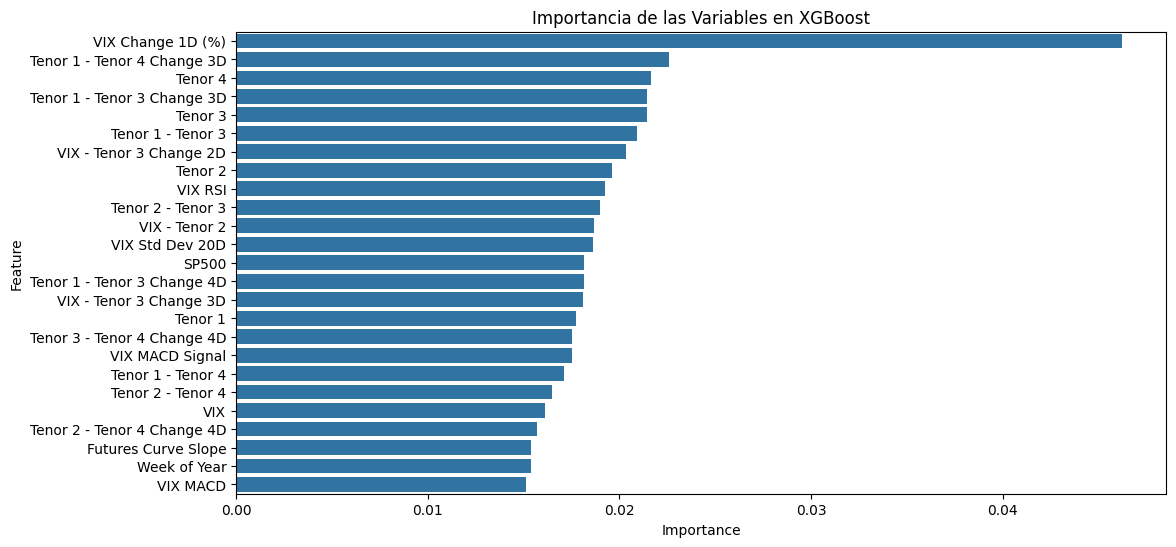

In [6]:
# Obtener importancias de las variables
feature_importance = best_model.feature_importances_

# Crear un DataFrame con los nombres de las variables y su importancia
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Ordenar de mayor a menor
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Gráfico de barras
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(25))  # Top 20
plt.title("Importancia de las Variables en XGBoost")
plt.show()

### PREDICCIONES EN TEST

In [7]:
# Predicciones en el conjunto de prueba

y_pred_encoded = best_model.predict(X_test)

# Decodificar las predicciones
y_pred = label_encoder.inverse_transform(y_pred_encoded)


Matriz de confusión:


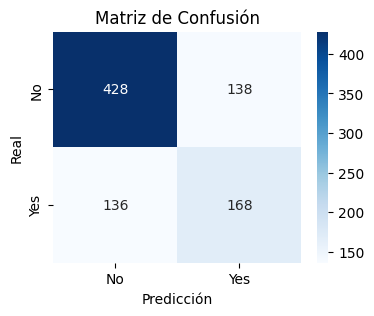


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       566
           1       0.55      0.55      0.55       304

    accuracy                           0.69       870
   macro avg       0.65      0.65      0.65       870
weighted avg       0.69      0.69      0.69       870


Precisión general:
0.6850574712643678


In [8]:
# Evaluación del modelo con el set de test
print("\nMatriz de confusión:")
plot_confusion_matrix(y_test, y_pred_encoded, labels=['No', 'Yes'])

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_encoded))

print("\nPrecisión general:")
print(accuracy_score(y_test, y_pred_encoded))

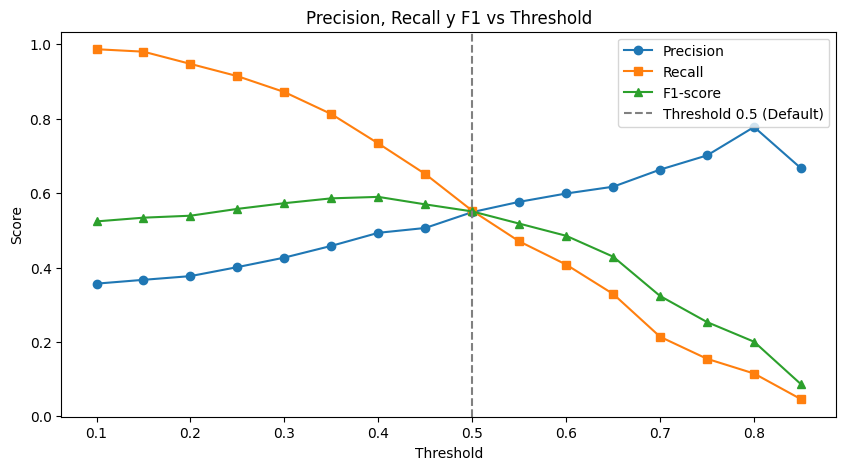

In [9]:
# Obtener probabilidades en lugar de predicciones binarias
y_pred_prob = random_search.best_estimator_.predict_proba(X_test)[:, 1]  # Probabilidad de ser "Yes"

# Probar diferentes umbrales
thresholds = np.arange(0.1, 0.9, 0.05)
precision_list = []
recall_list = []
f1_list = []

for threshold in thresholds:
    y_pred_adj = (y_pred_prob >= threshold).astype(int)
    report = classification_report(y_test, y_pred_adj, output_dict=True)
    
    precision_list.append(report["1"]["precision"])
    recall_list.append(report["1"]["recall"])
    f1_list.append(report["1"]["f1-score"])

# Graficar Precision-Recall vs. Threshold
plt.figure(figsize=(10,5))
plt.plot(thresholds, precision_list, label="Precision", marker='o')
plt.plot(thresholds, recall_list, label="Recall", marker='s')
plt.plot(thresholds, f1_list, label="F1-score", marker='^')
plt.axvline(0.5, linestyle="--", color="gray", label="Threshold 0.5 (Default)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision, Recall y F1 vs Threshold")
plt.show()

In [10]:
y_pred_prob

array([0.84812194, 0.3928455 , 0.28525007, 0.2629912 , 0.03509   ,
       0.8161987 , 0.17928803, 0.78695077, 0.3739941 , 0.16451588,
       0.33200994, 0.4604459 , 0.28092316, 0.48338827, 0.52563334,
       0.6353566 , 0.7667865 , 0.17650555, 0.63345146, 0.6059855 ,
       0.31439975, 0.35442322, 0.28690544, 0.734433  , 0.45188048,
       0.46229967, 0.31620926, 0.6725973 , 0.6441555 , 0.80147964,
       0.5371508 , 0.65218157, 0.55583966, 0.77662534, 0.2472579 ,
       0.24917367, 0.34653705, 0.38775608, 0.7161562 , 0.103416  ,
       0.22314894, 0.14064832, 0.52178794, 0.78856736, 0.55144805,
       0.24896327, 0.42349946, 0.3063936 , 0.6106159 , 0.1246063 ,
       0.41686663, 0.44541332, 0.22618859, 0.4566742 , 0.5004398 ,
       0.20122056, 0.27610776, 0.14787243, 0.47769696, 0.4869195 ,
       0.32426795, 0.38661444, 0.3464082 , 0.69924504, 0.50461864,
       0.3496666 , 0.6061936 , 0.44349545, 0.40027454, 0.30009034,
       0.23920952, 0.31392503, 0.8470406 , 0.5111255 , 0.49215

### PREDICCIONES AÑO 2025

In [11]:
# Separar features (X) y target (y)
X = data_last_y.drop(columns=['Spike in 5D'])
y = data_last_y['Spike in 5D']

# Codificar la variable objetivo (Yes=1, No=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Generar predicciones sobre el conjunto de prueba
y_pred_encoded = best_model.predict(X)

# Decodificar las predicciones
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Crear un DataFrame con las fechas de las predicciones 
predicted_dates = X.index

In [12]:
spikes_filtered = spikes[spikes['Year'] == 2025]

In [ ]:
def show_model_results():
    draw_predictions(y_pred_encoded, data_last_y, spikes_filtered)
    
    prediction_adjusted = calculate_spikes_predicted(y_pred,y,spikes_filtered)
    
    print("\nMatriz de confusión:")
    plot_confusion_matrix(y, y_pred, labels=['No', 'Yes'])

    print("\nReporte de clasificación:")
    print(classification_report(y, y_pred))

    print("\nPrecisión general:")
    print(accuracy_score(y, y_pred))

    # Evaluación del modelo con calculo de predicción ajustado
    print("\nMatriz de confusión:")
    plot_confusion_matrix(prediction_adjusted["Spike"], prediction_adjusted["Spike predicted confusion matrix"], labels=['No', 'Yes'])

    print("\nReporte de clasificación:")
    print(classification_report(prediction_adjusted["Spike"], prediction_adjusted["Spike predicted confusion matrix"]))

    print("\nPrecisión general:")
    print(accuracy_score(prediction_adjusted["Spike"], prediction_adjusted["Spike predicted confusion matrix"]))

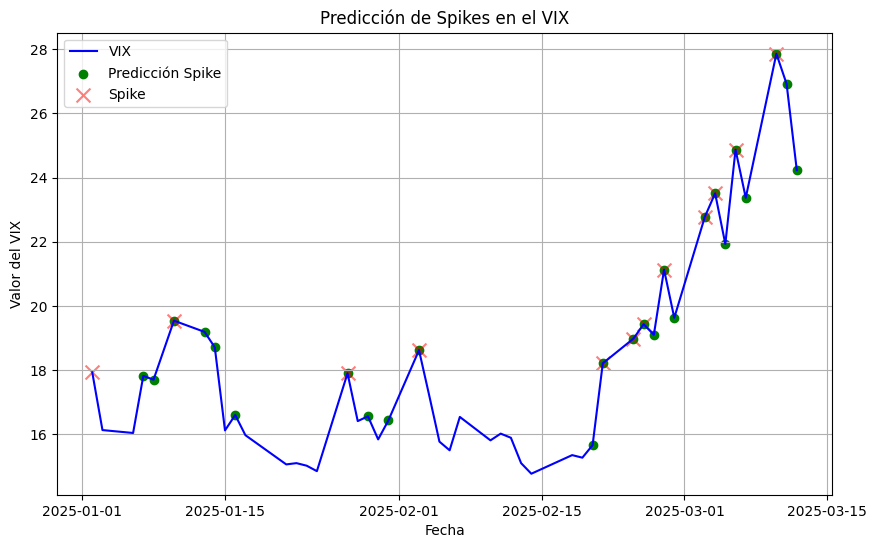

In [13]:
draw_predictions(y_pred_encoded, data_last_y, spikes_filtered)


Matriz de confusión:


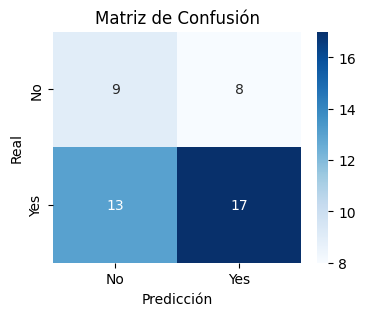


Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.41      0.53      0.46        17
         Yes       0.68      0.57      0.62        30

    accuracy                           0.55        47
   macro avg       0.54      0.55      0.54        47
weighted avg       0.58      0.55      0.56        47


Precisión general:
0.5531914893617021


In [14]:
# Evaluación del modelo con el set de test
print("\nMatriz de confusión:")
plot_confusion_matrix(y, y_pred, labels=['No', 'Yes'])

print("\nReporte de clasificación:")
print(classification_report(y, y_pred))

print("\nPrecisión general:")
print(accuracy_score(y, y_pred))

In [ ]:
# Señales falsas por cada una buena


In [ ]:
prediction_adjusted = calculate_spikes_predicted(y_pred,y,spikes_filtered)
prediction_adjusted

,Spike real en 5 D,Spike predicted?,Spike,Spike predicted actually,Spike predicted confusion matrix
Trade Date,,,,,
2025-01-02,No,No,Yes,No,No
2025-01-03,Yes,No,No,No,No
2025-01-06,Yes,No,No,No,No
2025-01-07,Yes,Yes,No,No,No
2025-01-08,Yes,Yes,No,No,No
2025-01-10,No,Yes,Yes,Yes,Yes
2025-01-13,No,Yes,No,No,Yes
2025-01-14,No,Yes,No,No,Yes
2025-01-15,No,No,No,No,No


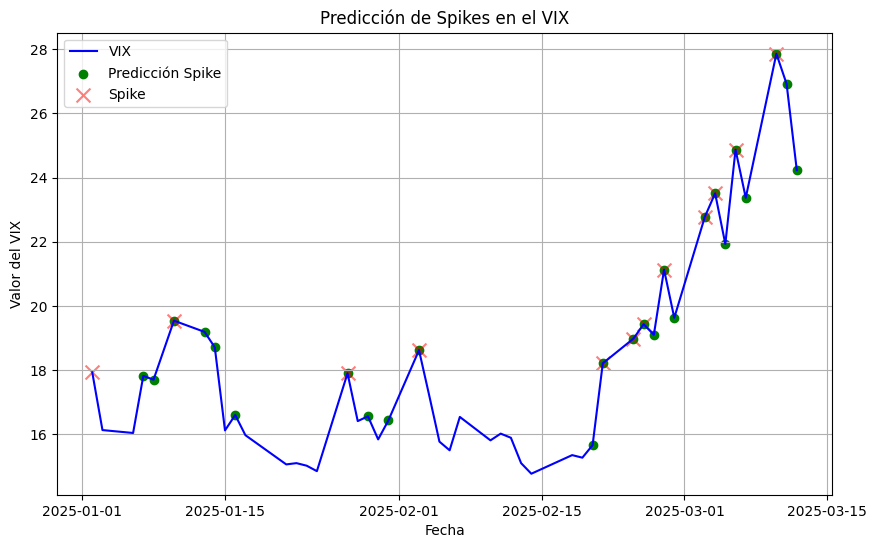

In [16]:
draw_predictions(y_pred_encoded, data_last_y, spikes_filtered)

In [17]:
prediction_adjusted.columns

Index(['Spike real en 5 D', 'Spike predicted?', 'Spike',
       'Spike predicted actually', 'Spike predicted confusion matrix'],
      dtype='object')


Matriz de confusión:


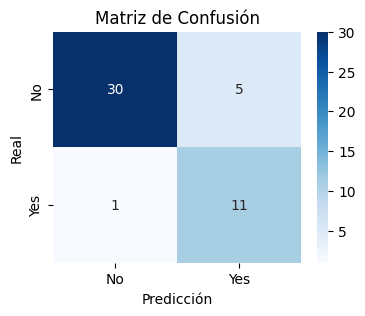


Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.97      0.86      0.91        35
         Yes       0.69      0.92      0.79        12

    accuracy                           0.87        47
   macro avg       0.83      0.89      0.85        47
weighted avg       0.90      0.87      0.88        47


Precisión general:
0.8723404255319149


In [25]:
# Evaluación del modelo con calculo de predicción ajustado
print("\nMatriz de confusión:")
plot_confusion_matrix(prediction_adjusted["Spike"], prediction_adjusted["Spike predicted confusion matrix"], labels=['No', 'Yes'])

print("\nReporte de clasificación:")
print(classification_report(prediction_adjusted["Spike"], prediction_adjusted["Spike predicted confusion matrix"]))

print("\nPrecisión general:")
print(accuracy_score(prediction_adjusted["Spike"], prediction_adjusted["Spike predicted confusion matrix"]))

In [291]:
# Separar features (X) y target (y)
X = data_last_y.drop(columns=['Spike in 5D'])
y = data_last_y['Spike in 5D']

# Codificar la variable objetivo (Yes=1, No=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Obtener las probabilidades de predicción
y_pred_prob = best_model.predict_proba(X)[:, 1]  # Probabilidad de ser "Yes"

# Definir un umbral personalizado (ajústalo según necesidad)
custom_threshold = 0.5
y_pred_adjusted = (y_pred_prob >= custom_threshold).astype(int)

# Decodificar las predicciones ajustadas
y_pred_final = label_encoder.inverse_transform(y_pred_adjusted)

# Crear un DataFrame con fechas y predicciones
predictions_df = pd.DataFrame({
    'Date': X.index,
    'Predicted Spike in 5D': y_pred_final,
    'Probability': y_pred_prob  # Opcional: Ver la probabilidad
})

# Mostrar las primeras filas
print(predictions_df.head())

        Date Predicted Spike in 5D  Probability
0 2025-01-02                    No     0.471682
1 2025-01-03                    No     0.146817
2 2025-01-06                    No     0.333093
3 2025-01-07                   Yes     0.687283
4 2025-01-08                   Yes     0.564945


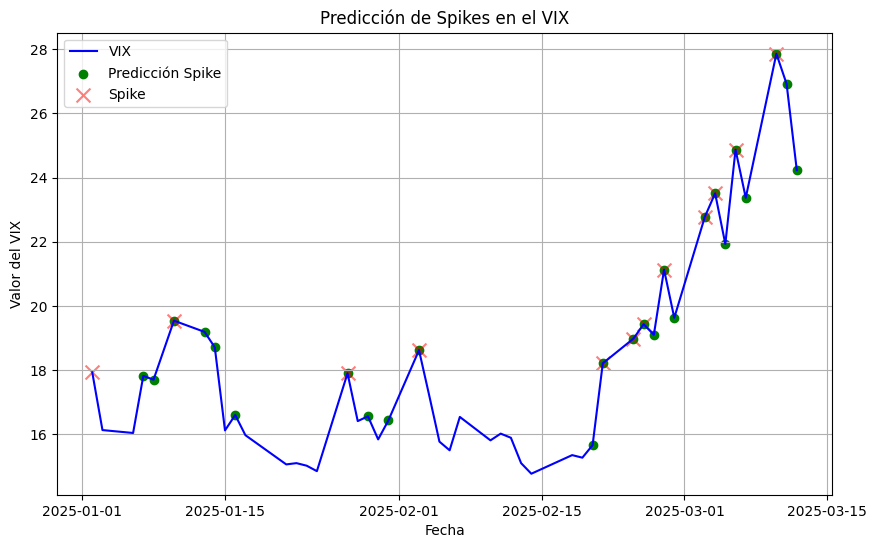

In [292]:
draw_predictions(y_pred_adjusted, data_last_y, spikes[spikes['Year'] == 2025])


Matriz de confusión:


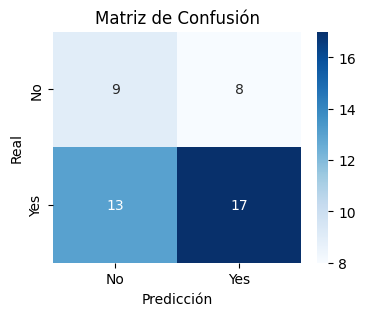


Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.41      0.53      0.46        17
         Yes       0.68      0.57      0.62        30

    accuracy                           0.55        47
   macro avg       0.54      0.55      0.54        47
weighted avg       0.58      0.55      0.56        47


Precisión general:
0.5531914893617021


In [294]:
# Evaluación del modelo con el set de test
print("\nMatriz de confusión:")
plot_confusion_matrix(y, y_pred_final, labels=['No', 'Yes'])

print("\nReporte de clasificación:")
print(classification_report(y, y_pred_final))

print("\nPrecisión general:")
print(accuracy_score(y, y_pred_final))

### PREDICCIONES AÑO 2024 y 2025

In [295]:
# Separar features (X) y target (y)
X = data_last_2y.drop(columns=['Spike in 5D'])
y = data_last_2y['Spike in 5D']

# Codificar la variable objetivo (Yes=1, No=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Generar predicciones sobre el conjunto de prueba
y_pred_encoded = best_model.predict(X)

# Decodificar las predicciones
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Crear un DataFrame con las fechas de las predicciones (solo las de la prueba)
predicted_dates = X.index

In [296]:
spikes_filtered = spikes[(spikes['Year'] == 2025)|(spikes['Year'] == 2024)]

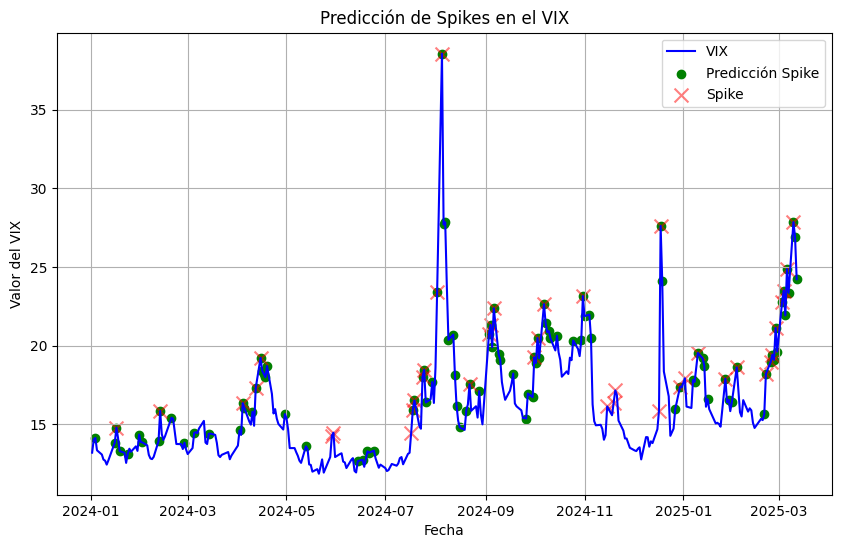

In [297]:
draw_predictions(y_pred_encoded, data_last_2y, spikes_filtered)


Matriz de confusión:


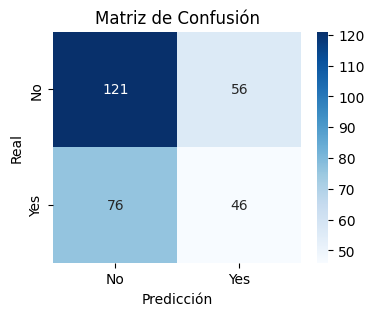


Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.61      0.68      0.65       177
         Yes       0.45      0.38      0.41       122

    accuracy                           0.56       299
   macro avg       0.53      0.53      0.53       299
weighted avg       0.55      0.56      0.55       299


Precisión general:
0.5585284280936454


In [298]:
# Evaluación del modelo
print("\nMatriz de confusión:")
plot_confusion_matrix(y, y_pred, labels=['No', 'Yes'])

print("\nReporte de clasificación:")
print(classification_report(y, y_pred))

print("\nPrecisión general:")
print(accuracy_score(y, y_pred))

In [299]:
# Separar features (X) y target (y)
X = data_last_2y.drop(columns=['Spike in 5D'])
y = data_last_2y['Spike in 5D']

# Codificar la variable objetivo (Yes=1, No=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Obtener las probabilidades de predicción
y_pred_prob = best_model.predict_proba(X)[:, 1]  # Probabilidad de ser "Yes"

# Definir un umbral personalizado (ajústalo según necesidad)
custom_threshold = 0.7
y_pred_adjusted = (y_pred_prob >= custom_threshold).astype(int)

# Decodificar las predicciones ajustadas
y_pred_final = label_encoder.inverse_transform(y_pred_adjusted)

# Crear un DataFrame con fechas y predicciones
predictions_df = pd.DataFrame({
    'Date': X.index,
    'Predicted Spike in 5D': y_pred_final,
    'Probability': y_pred_prob  # Opcional: Ver la probabilidad
})

# Mostrar las primeras filas
print(predictions_df.head())

        Date Predicted Spike in 5D  Probability
0 2024-01-02                    No     0.100433
1 2024-01-03                    No     0.232969
2 2024-01-04                    No     0.643715
3 2024-01-05                    No     0.485902
4 2024-01-08                    No     0.341019


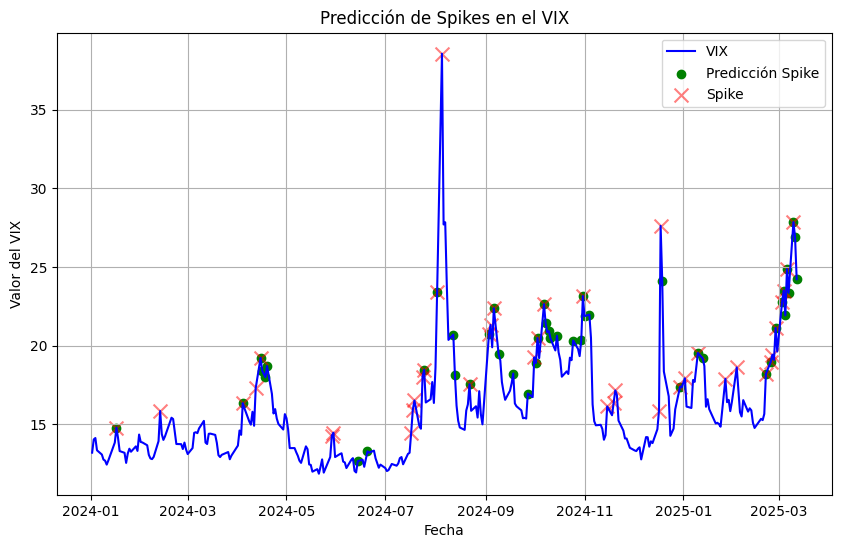

In [300]:
draw_predictions(y_pred_adjusted, data_last_2y, spikes_filtered)


Matriz de confusión:


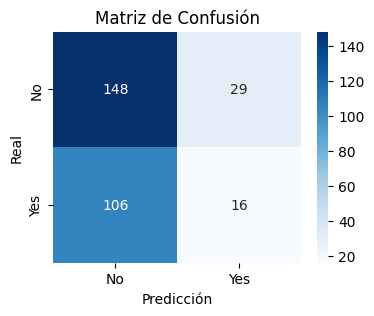


Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.58      0.84      0.69       177
         Yes       0.36      0.13      0.19       122

    accuracy                           0.55       299
   macro avg       0.47      0.48      0.44       299
weighted avg       0.49      0.55      0.48       299


Precisión general:
0.5484949832775919


In [325]:
# Evaluación del modelo
print("\nMatriz de confusión:")
plot_confusion_matrix(y, y_pred_final, labels=['No', 'Yes'])

print("\nReporte de clasificación:")
print(classification_report(y, y_pred_final))

print("\nPrecisión general:")
print(accuracy_score(y, y_pred_final))

In [301]:
spikes_filtered

,VIX,Year
Trade Date,,
2024-01-17,14.79,2024
2024-02-13,15.85,2024
2024-04-04,16.35,2024
2024-04-12,17.31,2024
2024-04-15,19.23,2024
2024-05-29,14.28,2024
2024-05-30,14.47,2024
2024-07-17,14.48,2024
2024-07-18,15.93,2024


In [322]:
prediction_adjusted = calculate_spikes_predicted(y_pred_final,y,spikes_filtered)
prediction_adjusted

,Spike real en 5 D,Spike predicted?,Spike,Spike predicted actually
Trade Date,,,,
2024-01-02,No,No,No,No
2024-01-03,No,No,No,No
2024-01-04,No,No,No,No
2024-01-05,No,No,No,No
2024-01-08,No,No,No,No
...,...,...,...,...
2025-03-06,Yes,Yes,Yes,Yes
2025-03-07,Yes,Yes,No,No
2025-03-10,No,Yes,Yes,Yes


In [ ]:
draw_predictions(y_pred_adjusted, data_last_2y, spikes_filtered)


Matriz de confusión:


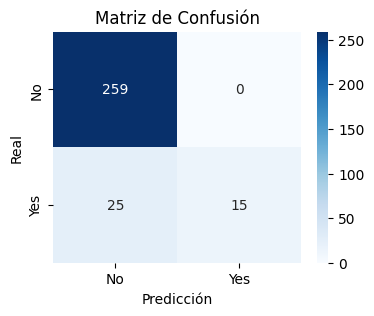


Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.91      1.00      0.95       259
         Yes       1.00      0.38      0.55        40

    accuracy                           0.92       299
   macro avg       0.96      0.69      0.75       299
weighted avg       0.92      0.92      0.90       299


Precisión general:
0.9163879598662207


In [323]:
# Evaluación del modelo con calculo de predicción ajustado
print("\nMatriz de confusión:")
plot_confusion_matrix(prediction_adjusted["Spike"], prediction_adjusted["Spike predicted actually"], labels=['No', 'Yes'])

print("\nReporte de clasificación:")
print(classification_report(prediction_adjusted["Spike"], prediction_adjusted["Spike predicted actually"]))

print("\nPrecisión general:")
print(accuracy_score(prediction_adjusted["Spike"], prediction_adjusted["Spike predicted actually"]))